# Deep Learning Course Project - Gesture Recognition
### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

  Gesture       Corresponding Action
- Thumbs Up     - Increase the volume.
- Thumbs Down   - Decrease the volume.
- Left Swipe    -'Jump' backwards 10 seconds.
- Right Swipe   -'Jump' forward 10 seconds.
- Stop          - Pause the movie.

Each video is a sequence of 30 frames (or images).

#### Objectives:
##### Generator: 
The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

##### Model: 
Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

##### Write up: 
This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

In [1]:
## importing the necessary libraries
import numpy as np
import os
from skimage.transform import resize
from imageio import imread
import matplotlib.pyplot as plt
import datetime
import abc
from abc import ABCMeta

# We set the random seed so that the results don't vary drastically.
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K

# %tensorflow_version 1.5
import tensorflow as tf
tf.compat.v1.set_random_seed(30)

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D , Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Input
from tensorflow.keras.applications import mobilenet
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau ,EarlyStopping
from keras import optimizers
     

In [2]:
project_folder_path='/datasets/Project_data'

1. This model class will handle all the initialisations of paths, image properties and model properties
2. This class will have a generator function as well for generating the data with labels
  - The images will be cropped to the size we want
  - The images with irregular dimension will be center cropped on the x-axis equally on both sides
  - We save the model only when the validation loss decreases
  - Learning rate decreases when approaching the minima
3. This class will have an abstract method to define our own model by inheriting this class
4. This class will have a generic train function as well,The history is saved to plot the model as well.

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with img_idx, y,z and normalization such that you get high accuracy.

In [3]:
class ModelClass(metaclass= ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder_path):
        self.train_doc = np.random.permutation(open(project_folder_path + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder_path + '/' + 'val.csv').readlines())
        self.train_path = project_folder_path + '/' + 'train'
        self.val_path =  project_folder_path + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)

    # initialising the image properties    
    def initialize_image_properties(self,image_height=120,image_width=120):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30

    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=32,num_epochs=50):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs

    def initialize_modelparams(self):
        self.model = None
        self.history = None

    def generator(self,source_path, folder_list, model_type = "Conv3D"):
      if model_type == "Conv3D":
        img_idx = [rn.randint(0, self.total_frames-1) for i in range(self.frames_to_sample)] #create a list of image numbers you want to use for a particular video
      else:
        img_idx = [i for i in range(self.frames_to_sample)] ## CNN+GRU
      # print(img_idx)
      while True:
          t = np.random.permutation(folder_list)
          num_batches = len(folder_list)//self.batch_size # calculate the number of batches
          for batch_no in range(num_batches): # we iterate over the number of batches
              batch_data = np.zeros((self.batch_size,len(img_idx),self.image_height,self.image_width,self.channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
              batch_labels = np.zeros((self.batch_size,self.num_classes)) # batch_labels is the one hot representation of the output
              for folder in range(self.batch_size): # iterate over the batch_size
                  imgs = os.listdir(source_path+'/'+ t[folder + (batch_no*self.batch_size)].split(';')[0]) # read all the images in the folder
                  # print("imgs: ",imgs)
                  for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                      image = imread(source_path+'/'+ t[folder + (batch_no*self.batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                      if image.shape == (360,360,3): ###if images are of 360 x 360
                        image = resize(image,(self.image_height,self.image_width,self.channels))
                      else:
                        image = image[:,(image.shape[0] - self.image_height ) // 2 : image.shape[0] - (image.shape[0] - self.image_height ) // 2] ### if lower quality just centre crop
                      #crop the images and resize them. Note that the images are of 2 different shape 
                      #and the conv3D will throw error if the inputs in a batch have different shapes
                      

                      batch_data[folder,idx,:,:,0] = image[:,:,0]/255.0 #normalise and feed in the image
                      batch_data[folder,idx,:,:,1] = image[:,:,1]/255.0 #normalise and feed in the image
                      batch_data[folder,idx,:,:,2] = image[:,:,2]/255.0 #normalise and feed in the image
                      
                  batch_labels[folder, int(t[folder + (batch_no*self.batch_size)].strip().split(';')[2])] = 1
              yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

          
      #     write the code for the remaining data points which are left after full batches
          left_images = len(folder_list)%self.batch_size
          left_overs = t[len(t)-left_images:]

          batch_data = np.zeros((left_images,len(img_idx),self.image_height,self.image_width,self.channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
          batch_labels = np.zeros((left_images,self.num_classes)) # batch_labels is the one hot representation of the output
          for folder in range(left_images): # iterate over the batch_size
              imgs = os.listdir(source_path+'/'+ left_overs[folder].split(';')[0]) # read all the images in the folder
              # print("imgs: ",imgs)
              for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                  image = imread(source_path+'/'+ left_overs[folder].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                  if image.shape == (360,360,3): ###if images are of 360 x 360
                        image = resize(image,(self.image_height,self.image_width,self.channels))
                  else:
                    image = image[:,(image.shape[0] - self.image_height ) // 2 : image.shape[0] - (image.shape[0] - self.image_height ) // 2] ### if lower quality just centre crop
                  #crop the images and resize them. Note that the images are of 2 different shape 
                  #and the conv3D will throw error if the inputs in a batch have different shapes
                  

                  batch_data[folder,idx,:,:,0] = image[:,:,0]/255.0 #normalise and feed in the image
                  batch_data[folder,idx,:,:,1] = image[:,:,1]/255.0 #normalise and feed in the image
                  batch_data[folder,idx,:,:,2] = image[:,:,2]/255.0 #normalise and feed in the image
                  
              batch_labels[folder, int(left_overs[folder].strip().split(';')[2])] = 1
          yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

    @abc.abstractmethod
    def model_architecture(self):
      pass

    def train_model(self,model,model_name="model_init",model_type="Conv3D"):
        train_generator = self.generator(self.train_path, self.train_doc,model_type=model_type)
        val_generator = self.generator(self.val_path, self.val_doc,model_type=model_type)

        model_name = model_name + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        # earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        self.history = history
        return history

    def plot_model(self):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
        axes[0].plot(self.history.history['loss'])   
        axes[0].plot(self.history.history['val_loss'])
        axes[0].legend(['loss','val_loss'])

        axes[1].plot(self.history.history['categorical_accuracy'])   
        axes[1].plot(self.history.history['val_categorical_accuracy'])
        axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

### Sample Image cropping is shown below

(120, 160, 3)


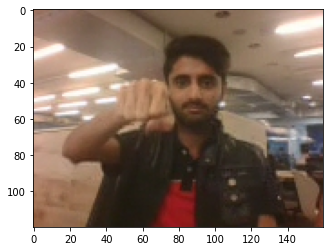

In [4]:
##actual image
image = imread('/datasets/Project_data/train/WIN_20180925_17_44_57_Pro_Thumbs_Down_new/WIN_20180925_17_44_57_Pro_00015.png')
print(image.shape)
plt.imshow(image/255)


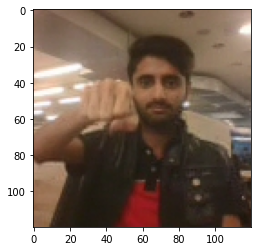

In [5]:
##centre cropping of the image looks like this for a (120,160) image
image = image[:,20:140]
plt.imshow(image)
plt.show()


# Model Building
### Approach 1: Conv3D model

Base model which has Conv3D + BatchNorm + MaxPooling3D layers lined up with a softmax at the end.

In [6]:
class Conv3D1(ModelClass):
    
    def model_architecture(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))


        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = "adam"
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model
     

## Model 1: Conv3D model 

- 15 frames to be sampled
- Batch size is 32
- Images cropped to (120,120)
- 128 dense neurons in the two dense layers

In [7]:
conv3D1 = Conv3D1()
conv3D1.initialize_path(project_folder_path)
conv3D1.initialize_image_properties(image_height=120,image_width=120)
conv3D1.initialize_hyperparams(frames_to_sample=15,batch_size=32,num_epochs=20)
conv3D1.initialize_modelparams()
conv3D1_model=conv3D1.model_architecture(dense_neurons=128,dropout=0.25)
conv3D1_model.summary()

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv3d (Conv3D)             (None, 15, 120, 120, 16)  1312      

                                                                 

 activation (Activation)     (None, 15, 120, 120, 16)  0         

                                                                 

 batch_normalization (BatchN  (None, 15, 120, 120, 16)  64       

 ormalization)                                                   

                                                                 

 max_pooling3d (MaxPooling3D  (None, 7, 60, 60, 16)    0         

 )                                                               

                                                                 

 conv3d_1 (Conv3D)           (None, 7, 60, 60, 32)     4128      

                                                                 

 activation_1 (Activation)   (None, 7, 6

2023-11-08 04:51:32.487043: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.

2023-11-08 04:51:32.487109: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:40:00.0, compute capability: 7.5


In [8]:
##train the model
conv3D1.train_model(conv3D1_model,model_name="conv3D1",model_type="Conv3D")

/tmp/ipykernel_303/4180867941.py:119: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/20


2023-11-06 07:51:18.415027: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.5195 - categorical_accuracy: 0.4570



Epoch 00001: val_loss improved from inf to 2.79291, saving model to /content/drive/MyDrive/conv3D1_2023-11-0607_51_14.525937/model-00001-1.51948-0.45701-2.79291-0.24000.h5



21/21 [==============================] - 61s 3s/step - loss: 1.5195 - categorical_accuracy: 0.4570 - val_loss: 2.7929 - val_categorical_accuracy: 0.2400 - lr: 0.0010



Epoch 2/20



21/21 [==============================] - ETA: 0s - loss: 0.8804 - categorical_accuracy: 0.6667



Epoch 00002: val_loss did not improve from 2.79291



21/21 [==============================] - 60s 3s/step - loss: 0.8804 - categorical_accuracy: 0.6667 - val_loss: 4.5910 - val_categorical_accuracy: 0.1700 - lr: 0.0010



Epoch 3/20



21/21 [==============================] - ETA: 0s - loss: 0.5936 - categorical_accuracy: 0.7768



Epoch 00003: val_loss did not improve from 2.79291



21/21 [==============================] - 58s 3s/step - lo

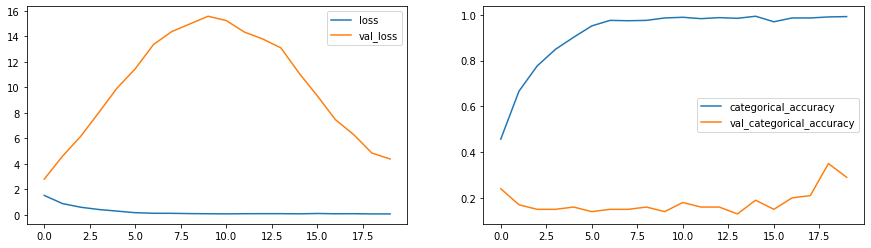

In [9]:
# plot the model
conv3D1.plot_model()

### Observations and Thoughts:

- Clearly overfitting with val accuracy just being around 29% and train accuracy reaching 99%
- Let's decrease the batch_size to reduce generalisability and increase the epochs and also increase the frames to sample

### Model 2: Conv3D model 

- 20 frames to be sampled
- Batch size is 20
- Images cropped to (120,120)
- 128 dense neurons in the two dense layers
- Epochs = 30

In [10]:
conv3D2 = Conv3D1()
conv3D2.initialize_path(project_folder_path)
conv3D2.initialize_image_properties(image_height=120,image_width=120)
conv3D2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=30)
conv3D2.initialize_modelparams()
conv3D2_model=conv3D2.model_architecture(dense_neurons=128,dropout=0.25)
conv3D2_model.summary()

Model: "sequential_1"



_________________________________________________________________



 Layer (type)                Output Shape              Param #   






 conv3d_4 (Conv3D)           (None, 20, 120, 120, 16)  1312      



                                                                 



 activation_4 (Activation)   (None, 20, 120, 120, 16)  0         



                                                                 



 batch_normalization_6 (Batc  (None, 20, 120, 120, 16)  64       



 hNormalization)                                                 



                                                                 



 max_pooling3d_4 (MaxPooling  (None, 10, 60, 60, 16)   0         



 3D)                                                             



                                                                 



 conv3d_5 (Conv3D)           (None, 10, 60, 60, 32)    4128      



                                                                 



 activ

In [11]:
##train the model
conv3D2.train_model(conv3D2_model,model_name="conv3D2",model_type="Conv3D")

/tmp/ipykernel_303/4180867941.py:119: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/30



34/34 [==============================] - ETA: 0s - loss: 1.5232 - categorical_accuracy: 0.4646



Epoch 00001: val_loss improved from inf to 3.02512, saving model to /content/drive/MyDrive/conv3D2_2023-11-0608_11_58.163137/model-00001-1.52319-0.46456-3.02512-0.16000.h5



34/34 [==============================] - 77s 2s/step - loss: 1.5232 - categorical_accuracy: 0.4646 - val_loss: 3.0251 - val_categorical_accuracy: 0.1600 - lr: 0.0010



Epoch 2/30



33/34 [============================>.] - ETA: 1s - loss: 0.8231 - categorical_accuracy: 0.6409



Epoch 00002: val_loss did not improve from 3.02512



34/34 [==============================] - 76s 2s/step - loss: 0.8260 - categorical_accuracy: 0.6395 - val_loss: 6.1187 - val_categorical_accuracy: 0.1600 - lr: 0.0010



Epoch 3/30



34/34 [==============================] - ETA: 0s - loss: 0.6304 - categorical_accuracy: 0.7451



Epoch 00003: val_loss did not improve from 3.02512



34/34 [==============================] - 76

### Observations and Thoughts:

- we have pushed the validation accuracy by a large extent from 29% to 73%
- We still see there is some gap between training and Validation accuracy which is around 24% where training accuracy is 97%
- We should try increasing dropout and decrease batch_size to see if it reduces the gap

### Model 3: Conv3D model 

- 20 frames to be sampled
- Batch size is 16 (perviously 20)
- Images cropped to (120,120)
- 128 dense neurons in the two dense layers
- Epochs = 30
- dropout = 0.5

In [12]:
conv3D3 = Conv3D1()
conv3D3.initialize_path(project_folder_path)
conv3D3.initialize_image_properties(image_height=120,image_width=120)
conv3D3.initialize_hyperparams(frames_to_sample=20,batch_size=16,num_epochs=30)
conv3D3.initialize_modelparams()
conv3D3_model=conv3D3.model_architecture(dense_neurons=128,dropout=0.5)
conv3D3_model.summary()

Model: "sequential_2"



_________________________________________________________________



 Layer (type)                Output Shape              Param #   






 conv3d_8 (Conv3D)           (None, 20, 120, 120, 16)  1312      



                                                                 



 activation_8 (Activation)   (None, 20, 120, 120, 16)  0         



                                                                 



 batch_normalization_12 (Bat  (None, 20, 120, 120, 16)  64       



 chNormalization)                                                



                                                                 



 max_pooling3d_8 (MaxPooling  (None, 10, 60, 60, 16)   0         



 3D)                                                             



                                                                 



 conv3d_9 (Conv3D)           (None, 10, 60, 60, 32)    4128      



                                                                 



 activ

In [13]:
#train the model
conv3D3.train_model(conv3D3_model,model_name="conv3D3",model_type="Conv3D")

/tmp/ipykernel_302/4180867941.py:119: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/30


2023-11-06 09:00:19.734406: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


42/42 [==============================] - ETA: 0s - loss: 1.9303 - categorical_accuracy: 0.3379



Epoch 00001: val_loss improved from inf to 2.87385, saving model to /content/drive/MyDrive/conv3D3_2023-11-0609_00_16.340759/model-00001-1.93031-0.33786-2.87385-0.18000.h5



42/42 [==============================] - 83s 2s/step - loss: 1.9303 - categorical_accuracy: 0.3379 - val_loss: 2.8738 - val_categorical_accuracy: 0.1800 - lr: 0.0010



Epoch 2/30



42/42 [==============================] - ETA: 0s - loss: 1.3180 - categorical_accuracy: 0.5053



Epoch 00002: val_loss did not improve from 2.87385



42/42 [==============================] - 80s 2s/step - loss: 1.3180 - categorical_accuracy: 0.5053 - val_loss: 5.3292 - val_categorical_accuracy: 0.1800 - lr: 0.0010



Epoch 3/30



42/42 [==============================] - ETA: 0s - loss: 1.2422 - categorical_accuracy: 0.5294



Epoch 00003: val_loss did not improve from 2.87385



42/42 [==============================] - 78s 2s/step - lo

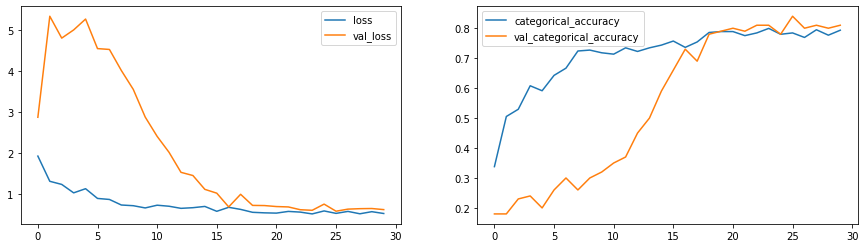

In [14]:
conv3D3.plot_model()

### Observations and Thoughts:

- We have now reduced the gap between training and validation accuracy, thereby completely overcoming overfitting.
- We see that least validation loss is at 0.5910
- We had a loss: 0.5384 - categorical_accuracy: 0.7843 - val_loss: 0.5910 - val_categorical_accuracy: 0.8400
- We see that the training accuracy is lesser than the validation accuracy.

     - This happens when the validation set is easier to interpret than the training set.
     - This is NOT a negative sign and is much realistic as you see that the training and validation loss are very close by similar to categorical accuracies.
- Let's try a few more models like above using different kernel size to see if we see some more improvement

### Model 4: Conv3D model 

- 15 frames to be sampled
- Batch size is 32
- Images cropped to (120,120)
- 128 dense neurons in the two dense layers
- Epochs = 20
- dropout = 0.25
- kernel size = (3,3,3)

In [15]:
class Conv3D4(ModelClass):
    
    def model_architecture(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))


        model.add(Conv3D(128, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = "adam"
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [16]:
conv3D4 = Conv3D4()
conv3D4.initialize_path(project_folder_path)
conv3D4.initialize_image_properties(image_height=120,image_width=120)
conv3D4.initialize_hyperparams(frames_to_sample=15,batch_size=32,num_epochs=20)
conv3D4.initialize_modelparams()
conv3D4_model=conv3D4.model_architecture(dense_neurons=128,dropout=0.25)
conv3D4_model.summary()

Model: "sequential_3"



_________________________________________________________________



 Layer (type)                Output Shape              Param #   






 conv3d_12 (Conv3D)          (None, 15, 120, 120, 16)  1312      



                                                                 



 activation_12 (Activation)  (None, 15, 120, 120, 16)  0         



                                                                 



 batch_normalization_18 (Bat  (None, 15, 120, 120, 16)  64       



 chNormalization)                                                



                                                                 



 max_pooling3d_12 (MaxPoolin  (None, 7, 60, 60, 16)    0         



 g3D)                                                            



                                                                 



 conv3d_13 (Conv3D)          (None, 7, 60, 60, 32)     13856     



                                                                 



 activ

In [17]:
conv3D4.train_model(conv3D4_model,model_name="conv3D4",model_type="Conv3D")

/tmp/ipykernel_302/4180867941.py:119: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/20



21/21 [==============================] - ETA: 0s - loss: 1.5983 - categorical_accuracy: 0.4419



Epoch 00001: val_loss improved from inf to 1.70522, saving model to /content/drive/MyDrive/conv3D4_2023-11-0609_40_54.505295/model-00001-1.59827-0.44193-1.70522-0.16000.h5



21/21 [==============================] - 63s 3s/step - loss: 1.5983 - categorical_accuracy: 0.4419 - val_loss: 1.7052 - val_categorical_accuracy: 0.1600 - lr: 0.0010



Epoch 2/20



21/21 [==============================] - ETA: 0s - loss: 0.8385 - categorical_accuracy: 0.6802



Epoch 00002: val_loss did not improve from 1.70522



21/21 [==============================] - 60s 3s/step - loss: 0.8385 - categorical_accuracy: 0.6802 - val_loss: 1.8327 - val_categorical_accuracy: 0.1800 - lr: 0.0010



Epoch 3/20



21/21 [==============================] - ETA: 0s - loss: 0.6021 - categorical_accuracy: 0.7828



Epoch 00003: val_loss did not improve from 1.70522



21/21 [==============================] - 61

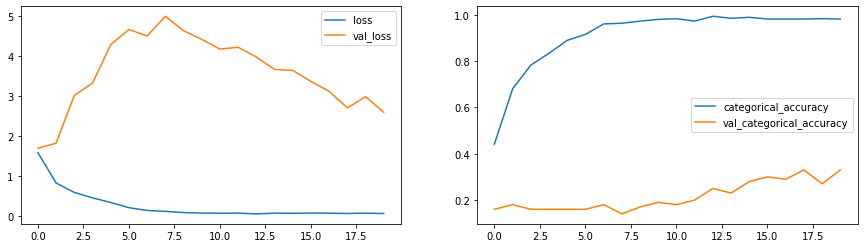

In [18]:
conv3D4.plot_model()

### Observations and Thoughts:

- A case of complete overfitting is seen here.
- Lets reduce the batch size

### Model 5: Conv3D model 

- 15 frames to be sampled
- Batch size is 20
- Images cropped to (120,120)
- 128 dense neurons in the two dense layers
- Epochs = 10
- dropout = 0.25
- kernel size = (3,3,3)

In [19]:
conv3D5 = Conv3D4()
conv3D5.initialize_path(project_folder_path)
conv3D5.initialize_image_properties(image_height=120,image_width=120)
conv3D5.initialize_hyperparams(frames_to_sample=15,batch_size=20,num_epochs=10)
conv3D5.initialize_modelparams()
conv3D5_model=conv3D5.model_architecture(dense_neurons=128,dropout=0.25)
conv3D5_model.summary()

Model: "sequential_4"



_________________________________________________________________



 Layer (type)                Output Shape              Param #   






 conv3d_16 (Conv3D)          (None, 15, 120, 120, 16)  1312      



                                                                 



 activation_16 (Activation)  (None, 15, 120, 120, 16)  0         



                                                                 



 batch_normalization_24 (Bat  (None, 15, 120, 120, 16)  64       



 chNormalization)                                                



                                                                 



 max_pooling3d_16 (MaxPoolin  (None, 7, 60, 60, 16)    0         



 g3D)                                                            



                                                                 



 conv3d_17 (Conv3D)          (None, 7, 60, 60, 32)     13856     



                                                                 



 activ

In [20]:
conv3D5.train_model(conv3D5_model,model_name="conv3D5",model_type="Conv3D")

/tmp/ipykernel_302/4180867941.py:119: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/10



34/34 [==============================] - ETA: 0s - loss: 1.5521 - categorical_accuracy: 0.4555



Epoch 00001: val_loss improved from inf to 1.85520, saving model to /content/drive/MyDrive/conv3D5_2023-11-0610_01_33.346418/model-00001-1.55206-0.45551-1.85520-0.28000.h5



34/34 [==============================] - 60s 2s/step - loss: 1.5521 - categorical_accuracy: 0.4555 - val_loss: 1.8552 - val_categorical_accuracy: 0.2800 - lr: 0.0010



Epoch 2/10



34/34 [==============================] - ETA: 0s - loss: 1.1098 - categorical_accuracy: 0.5641



Epoch 00002: val_loss did not improve from 1.85520



34/34 [==============================] - 59s 2s/step - loss: 1.1098 - categorical_accuracy: 0.5641 - val_loss: 2.4630 - val_categorical_accuracy: 0.1900 - lr: 0.0010



Epoch 3/10



34/34 [==============================] - ETA: 0s - loss: 1.1682 - categorical_accuracy: 0.5777



Epoch 00003: val_loss did not improve from 1.85520



34/34 [==============================] - 58

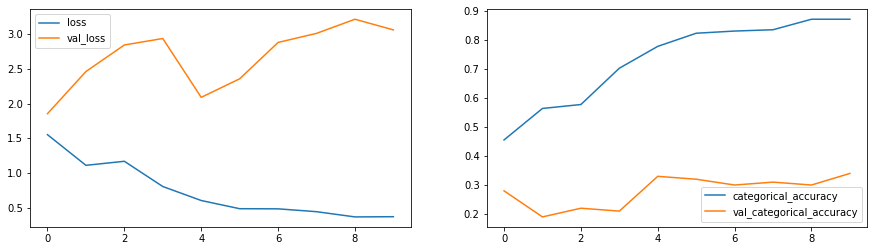

In [21]:
conv3D5.plot_model()

### Observations and Thoughts:

- We can see the model is still overfitting,we can reduce the overfitting by a large extent.(By inceasing the Epochs)

### Model 6: Conv3D model with

- 15 frames to be sampled
- Batch size is 20
- Images cropped to (120,120)
- 128 dense neurons in the two dense layers
- Epochs = 10
- dropout = 0.25
- kernel size = (3,3,3)

In [22]:
conv3D6 = Conv3D4()
conv3D6.initialize_path(project_folder_path)
conv3D6.initialize_image_properties(image_height=120,image_width=120)
conv3D6.initialize_hyperparams(frames_to_sample=15,batch_size=20,num_epochs=10)
conv3D6.initialize_modelparams()
conv3D6_model=conv3D6.model_architecture(dense_neurons=128,dropout=0.25)
conv3D6_model.summary()

Model: "sequential_5"



_________________________________________________________________



 Layer (type)                Output Shape              Param #   






 conv3d_20 (Conv3D)          (None, 15, 120, 120, 16)  1312      



                                                                 



 activation_20 (Activation)  (None, 15, 120, 120, 16)  0         



                                                                 



 batch_normalization_30 (Bat  (None, 15, 120, 120, 16)  64       



 chNormalization)                                                



                                                                 



 max_pooling3d_20 (MaxPoolin  (None, 7, 60, 60, 16)    0         



 g3D)                                                            



                                                                 



 conv3d_21 (Conv3D)          (None, 7, 60, 60, 32)     13856     



                                                                 



 activ

In [23]:
conv3D6.train_model(conv3D6_model,model_name="conv3D6",model_type="Conv3D")

/tmp/ipykernel_302/4180867941.py:119: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/10



34/34 [==============================] - ETA: 0s - loss: 1.5964 - categorical_accuracy: 0.4238



Epoch 00001: val_loss improved from inf to 2.59804, saving model to /content/drive/MyDrive/conv3D6_2023-11-0610_11_27.972308/model-00001-1.59640-0.42383-2.59804-0.16000.h5



34/34 [==============================] - 60s 2s/step - loss: 1.5964 - categorical_accuracy: 0.4238 - val_loss: 2.5980 - val_categorical_accuracy: 0.1600 - lr: 0.0010



Epoch 2/10



33/34 [============================>.] - ETA: 1s - loss: 1.1435 - categorical_accuracy: 0.5545



Epoch 00002: val_loss did not improve from 2.59804



34/34 [==============================] - 59s 2s/step - loss: 1.1506 - categorical_accuracy: 0.5520 - val_loss: 6.2168 - val_categorical_accuracy: 0.1600 - lr: 0.0010



Epoch 3/10



34/34 [==============================] - ETA: 0s - loss: 1.0096 - categorical_accuracy: 0.6229



Epoch 00003: val_loss did not improve from 2.59804



34/34 [==============================] - 59

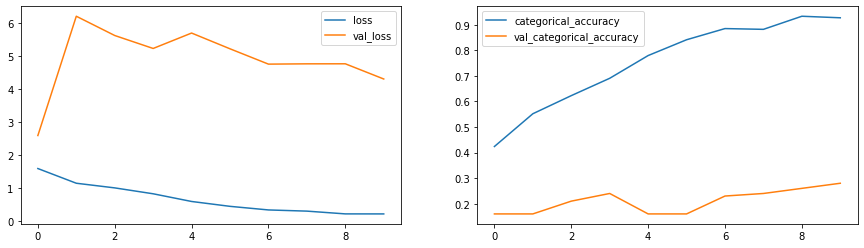

In [24]:
conv3D6.plot_model()

### Observations and Thoughts:

- Let’s add more convolutional  layers.

### Model 7: Conv3D model with added convolutional layers

- 15 frames to be sampled
- Batch size is 32
- Images cropped to (120,120)
- 128 dense neurons in the two dense layers
- Epochs = 10
- dropout = 0.25
- kernel size = (2,2,2)

In [25]:
class Conv3D7(ModelClass):
    
    def model_architecture(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

        model.add(Conv3D(256, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

        model.add(Conv3D(512, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = "adam"
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model
     

In [26]:
conv3D7 = Conv3D7()
conv3D7.initialize_path(project_folder_path)
conv3D7.initialize_image_properties(image_height=120,image_width=120)
conv3D7.initialize_hyperparams(frames_to_sample=15,batch_size=32,num_epochs=10)
conv3D7.initialize_modelparams()
conv3D7_model=conv3D7.model_architecture(dense_neurons=128,dropout=0.25)
conv3D7_model.summary()

Model: "sequential_6"



_________________________________________________________________



 Layer (type)                Output Shape              Param #   






 conv3d_24 (Conv3D)          (None, 15, 120, 120, 16)  1312      



                                                                 



 activation_24 (Activation)  (None, 15, 120, 120, 16)  0         



                                                                 



 batch_normalization_36 (Bat  (None, 15, 120, 120, 16)  64       



 chNormalization)                                                



                                                                 



 max_pooling3d_24 (MaxPoolin  (None, 7, 60, 60, 16)    0         



 g3D)                                                            



                                                                 



 conv3d_25 (Conv3D)          (None, 7, 60, 60, 32)     4128      



                                                                 



 activ

In [27]:
##train the model
conv3D7.train_model(conv3D7_model,model_name="conv3D7",model_type="Conv3D")

/tmp/ipykernel_302/4180867941.py:119: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/10



21/21 [==============================] - ETA: 0s - loss: 1.6754 - categorical_accuracy: 0.3801



Epoch 00001: val_loss improved from inf to 1.65940, saving model to /content/drive/MyDrive/conv3D7_2023-11-0610_21_27.319401/model-00001-1.67543-0.38009-1.65940-0.16000.h5



21/21 [==============================] - 62s 3s/step - loss: 1.6754 - categorical_accuracy: 0.3801 - val_loss: 1.6594 - val_categorical_accuracy: 0.1600 - lr: 0.0010



Epoch 2/10



21/21 [==============================] - ETA: 0s - loss: 1.2401 - categorical_accuracy: 0.5234



Epoch 00002: val_loss did not improve from 1.65940



21/21 [==============================] - 61s 3s/step - loss: 1.2401 - categorical_accuracy: 0.5234 - val_loss: 1.8605 - val_categorical_accuracy: 0.1500 - lr: 0.0010



Epoch 3/10



21/21 [==============================] - ETA: 0s - loss: 0.9457 - categorical_accuracy: 0.6109



Epoch 00003: val_loss did not improve from 1.65940



21/21 [==============================] - 61

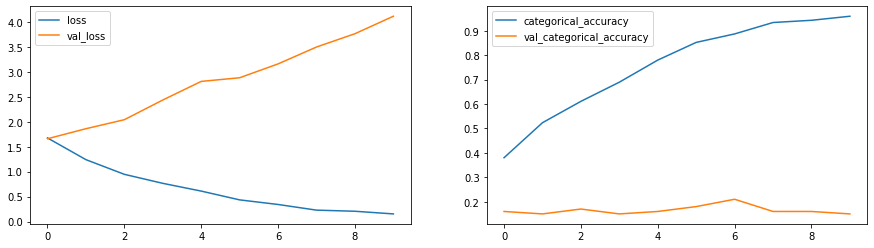

In [28]:
# plot the model
conv3D7.plot_model()

### Observations and Thoughts:

- Clearly overfitting with val accuracy just being around 15% and train accuracy reaching 95%+
- Let's decrease the batch_size to increase generalisability.


### Model 8: Conv3D model with added convolutional layers

- 15 frames to be sampled
- Batch size is 20
- Images cropped to (120,120)
- 128 dense neurons in the two dense layers
- Epochs = 20
- dropout = 0.25
- kernel size = (2,2,2)

In [29]:
conv3D8 = Conv3D7()
conv3D8.initialize_path(project_folder_path)
conv3D8.initialize_image_properties(image_height=120,image_width=120)
conv3D8.initialize_hyperparams(frames_to_sample=15,batch_size=20,num_epochs=20)
conv3D8.initialize_modelparams()
conv3D8_model=conv3D8.model_architecture(dense_neurons=128,dropout=0.25)
conv3D8_model.summary()

Model: "sequential_7"



_________________________________________________________________



 Layer (type)                Output Shape              Param #   






 conv3d_31 (Conv3D)          (None, 15, 120, 120, 16)  1312      



                                                                 



 activation_31 (Activation)  (None, 15, 120, 120, 16)  0         



                                                                 



 batch_normalization_45 (Bat  (None, 15, 120, 120, 16)  64       



 chNormalization)                                                



                                                                 



 max_pooling3d_31 (MaxPoolin  (None, 7, 60, 60, 16)    0         



 g3D)                                                            



                                                                 



 conv3d_32 (Conv3D)          (None, 7, 60, 60, 32)     4128      



                                                                 



 activ

In [30]:

##train the model
conv3D8.train_model(conv3D8_model,model_name="conv3D8",model_type="Conv3D")

/tmp/ipykernel_302/4180867941.py:119: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/20



34/34 [==============================] - ETA: 0s - loss: 1.6934 - categorical_accuracy: 0.3650



Epoch 00001: val_loss improved from inf to 1.65749, saving model to /content/drive/MyDrive/conv3D8_2023-11-0610_31_41.545830/model-00001-1.69338-0.36501-1.65749-0.21000.h5



34/34 [==============================] - 60s 2s/step - loss: 1.6934 - categorical_accuracy: 0.3650 - val_loss: 1.6575 - val_categorical_accuracy: 0.2100 - lr: 0.0010



Epoch 2/20



33/34 [============================>.] - ETA: 1s - loss: 1.2871 - categorical_accuracy: 0.4924



Epoch 00002: val_loss did not improve from 1.65749



34/34 [==============================] - 57s 2s/step - loss: 1.2909 - categorical_accuracy: 0.4917 - val_loss: 1.8323 - val_categorical_accuracy: 0.1600 - lr: 0.0010



Epoch 3/20



34/34 [==============================] - ETA: 0s - loss: 1.0757 - categorical_accuracy: 0.5897



Epoch 00003: val_loss did not improve from 1.65749



34/34 [==============================] - 58

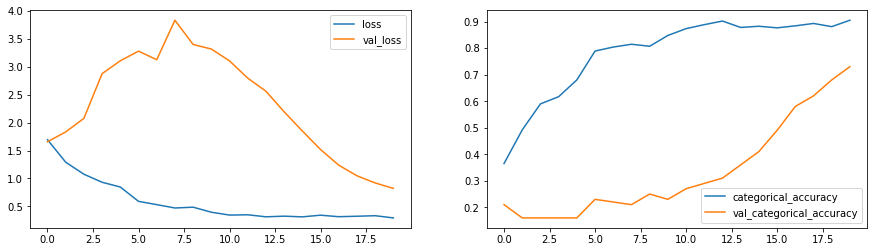

In [31]:
conv3D8.plot_model()

### Observations and Thoughts:

- Validation accuracy improved from 15% to 73%. Training accuracy decreased from 95% to 90%
Let's increase the epochs to see if validation increases further

## Model 9: Conv3D model with added convolutional layers and 40 epochs

- 15 frames to be sampled
- Batch size is 20
- Images cropped to (120,120)
- 128 dense neurons in the two dense layers
- Epochs = 20
- dropout = 0.25
- kernel size = (2,2,2)

In [32]:
conv3D9 = Conv3D7()
conv3D9.initialize_path(project_folder_path)
conv3D9.initialize_image_properties(image_height=120,image_width=120)
conv3D9.initialize_hyperparams(frames_to_sample=15,batch_size=20,num_epochs=20)
conv3D9.initialize_modelparams()
conv3D9_model=conv3D9.model_architecture(dense_neurons=128,dropout=0.25)
conv3D9_model.summary()

Model: "sequential_8"



_________________________________________________________________



 Layer (type)                Output Shape              Param #   






 conv3d_38 (Conv3D)          (None, 15, 120, 120, 16)  1312      



                                                                 



 activation_38 (Activation)  (None, 15, 120, 120, 16)  0         



                                                                 



 batch_normalization_54 (Bat  (None, 15, 120, 120, 16)  64       



 chNormalization)                                                



                                                                 



 max_pooling3d_38 (MaxPoolin  (None, 7, 60, 60, 16)    0         



 g3D)                                                            



                                                                 



 conv3d_39 (Conv3D)          (None, 7, 60, 60, 32)     4128      



                                                                 



 activ

In [33]:
##train the model
conv3D9.train_model(conv3D9_model,model_name="conv3D9",model_type="Conv3D")

/tmp/ipykernel_302/4180867941.py:119: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/20



34/34 [==============================] - ETA: 0s - loss: 1.7461 - categorical_accuracy: 0.3695



Epoch 00001: val_loss improved from inf to 1.72901, saving model to /content/drive/MyDrive/conv3D9_2023-11-0610_51_05.914792/model-00001-1.74612-0.36953-1.72901-0.16000.h5



34/34 [==============================] - 60s 2s/step - loss: 1.7461 - categorical_accuracy: 0.3695 - val_loss: 1.7290 - val_categorical_accuracy: 0.1600 - lr: 0.0010



Epoch 2/20



34/34 [==============================] - ETA: 0s - loss: 1.4155 - categorical_accuracy: 0.4691



Epoch 00002: val_loss did not improve from 1.72901



34/34 [==============================] - 58s 2s/step - loss: 1.4155 - categorical_accuracy: 0.4691 - val_loss: 1.8580 - val_categorical_accuracy: 0.2300 - lr: 0.0010



Epoch 3/20



33/34 [============================>.] - ETA: 1s - loss: 1.1911 - categorical_accuracy: 0.5121



Epoch 00003: val_loss did not improve from 1.72901



34/34 [==============================] - 58

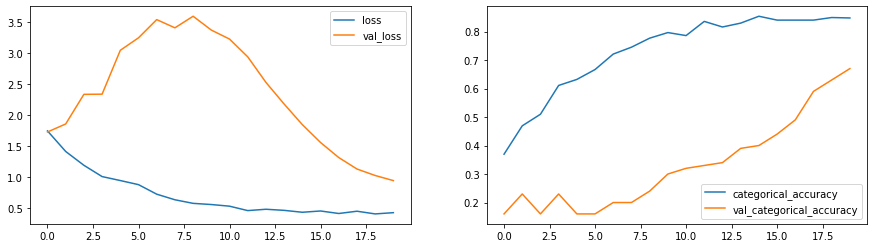

In [ ]:
conv3D9.plot_model()

### Observations and Thoughts:

- Validation accuracy decreased from 73% to 67%. Training accuracy also decreased from 90% to 84%

# Approach 2: CNN+GRU Models

- CNN will act as the feature extractor
- GRU will help us with the TimeSeries prediction of the images

ConvGRU class is extension of ModelClass with a different architecture CNN+GRU

- Base Model with few conv2D- BatchNorm - maxPool ordered layers
- Using GRU instead of LSTM to avoid more parameters, as we want to deploy on mobile applications and smart TV.

### Model 10: Conv2D+GRU

- 18 frames to be sampled
- Batch size is 20
- Images cropped to (120,120)
- 128 dense neurons in the two dense layers
- Epochs = 20
- dropout = 0.25
- gru cells = 128

In [6]:
class ConvGRU(ModelClass):
    
    def model_architecture(self,gru_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = "adam"
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        self.model = model
        return model

In [7]:
conv_gru = ConvGRU()
conv_gru.initialize_path(project_folder_path)
conv_gru.initialize_image_properties(image_height=120,image_width=120)
conv_gru.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
conv_gru.initialize_modelparams()
conv_gru_model=conv_gru.model_architecture(gru_cells=128,dense_neurons=128,dropout=0.25)
conv_gru_model.summary()

2023-11-07 13:25:21.241354: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.



2023-11-07 13:25:21.241416: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


Model: "sequential"



_________________________________________________________________



 Layer (type)                Output Shape              Param #   






 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      



 ibuted)                                                         



                                                                 



 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       



 tributed)                                                       



                                                                 



 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         



 tributed)                                                       



                                                                 



 time_distributed_3 (TimeDis  (None, 18, 60, 60, 32)   4640      



 tributed)                                                       



                                                                 



 time_di

/tmp/ipykernel_302/4180867941.py:119: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/20



34/34 [==============================] - ETA: 0s - loss: 1.4972 - categorical_accuracy: 0.3982



Epoch 00001: val_loss improved from inf to 1.81710, saving model to /content/drive/MyDrive/conv_gru_2023-11-0611_10_28.677606/model-00001-1.49722-0.39819-1.81710-0.26000.h5



34/34 [==============================] - 72s 2s/step - loss: 1.4972 - categorical_accuracy: 0.3982 - val_loss: 1.8171 - val_categorical_accuracy: 0.2600 - lr: 0.0010



Epoch 2/20



34/34 [==============================] - ETA: 0s - loss: 1.1282 - categorical_accuracy: 0.5309



Epoch 00002: val_loss did not improve from 1.81710



34/34 [==============================] - 69s 2s/step - loss: 1.1282 - categorical_accuracy: 0.5309 - val_loss: 2.6647 - val_categorical_accuracy: 0.2100 - lr: 0.0010



Epoch 3/20



34/34 [==============================] - ETA: 0s - loss: 0.9326 - categorical_accuracy: 0.6456



Epoch 00003: val_loss did not improve from 1.81710



34/34 [==============================] - 6

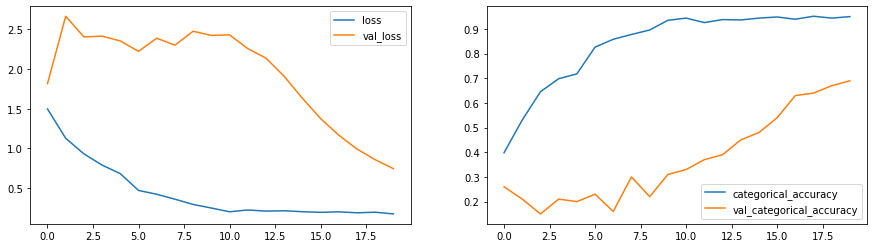

In [ ]:
conv_gru.train_model(conv_gru_model,model_name="conv_gru",model_type="CNN_GRU")
conv_gru.plot_model()

### Observations and Thoughts:

- We see loss: 0.1764 - categorical_accuracy: 0.9502 - val_loss: 0.7467 - val_categorical_accuracy: 0.6900 
- We see a training loss and validation loss less than 1
- Accuracies are 95% and 69% which is a sign of overfitting
- Lets increase dropout and increase batch size to see if it reduces overfitting.

### Model 11: Conv2D+GRU

- 20 frames to be sampled
- Batch size is 32 
- Images cropped to 120,120
- 128 dense neurons
- Epochs = 25
- dropout = 0.5
- gru cells = 128

In [10]:
conv_gru2 = ConvGRU()
conv_gru2.initialize_path(project_folder_path)
conv_gru2.initialize_image_properties(image_height=120,image_width=120)
conv_gru2.initialize_hyperparams(frames_to_sample=20,batch_size=32,num_epochs=25)
conv_gru2.initialize_modelparams()
conv_gru_model2=conv_gru2.model_architecture(gru_cells=128,dense_neurons=128,dropout=0.5)
conv_gru_model2.summary()

Model: "sequential_1"



_________________________________________________________________



 Layer (type)                Output Shape              Param #   






 time_distributed_16 (TimeDi  (None, 20, 120, 120, 16)  448      



 stributed)                                                      



                                                                 



 time_distributed_17 (TimeDi  (None, 20, 120, 120, 16)  64       



 stributed)                                                      



                                                                 



 time_distributed_18 (TimeDi  (None, 20, 60, 60, 16)   0         



 stributed)                                                      



                                                                 



 time_distributed_19 (TimeDi  (None, 20, 60, 60, 32)   4640      



 stributed)                                                      



                                                                 



 time_

/tmp/ipykernel_302/4180867941.py:119: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/25



21/21 [==============================] - ETA: 0s - loss: 1.7730 - categorical_accuracy: 0.3107



Epoch 00001: val_loss improved from inf to 1.66549, saving model to /content/drive/MyDrive/conv_gru2_2023-11-0611_33_50.061356/model-00001-1.77300-0.31071-1.66549-0.18000.h5



21/21 [==============================] - 81s 4s/step - loss: 1.7730 - categorical_accuracy: 0.3107 - val_loss: 1.6655 - val_categorical_accuracy: 0.1800 - lr: 0.0010



Epoch 2/25



21/21 [==============================] - ETA: 0s - loss: 1.5123 - categorical_accuracy: 0.3710



Epoch 00002: val_loss did not improve from 1.66549



21/21 [==============================] - 78s 4s/step - loss: 1.5123 - categorical_accuracy: 0.3710 - val_loss: 1.9616 - val_categorical_accuracy: 0.2200 - lr: 0.0010



Epoch 3/25



21/21 [==============================] - ETA: 0s - loss: 1.3585 - categorical_accuracy: 0.4555



Epoch 00003: val_loss did not improve from 1.66549



21/21 [==============================] - 

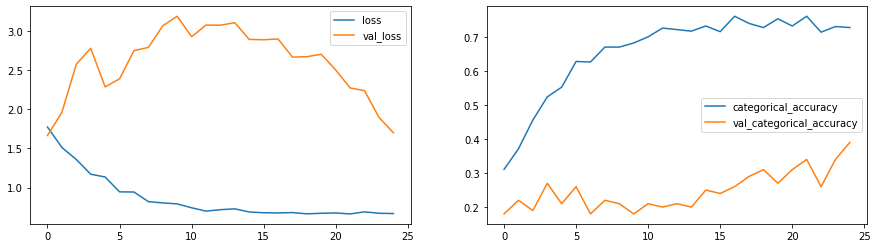

In [39]:
conv_gru2.train_model(conv_gru_model2,model_name="conv_gru2",model_type="CNN_GRU")
conv_gru2.plot_model()

### Observations and Thoughts:

- Increasing the batch size didnot help and also increased the overfitting by a large extent.
- The models accuracy on validation decreased from 69 to 39%.
- Instead of working on scratch models here, lets kick in with transfer learning for better image representation.
- Lets now try to use transfer learning with MobileNet which is known to be the most prominent set of weights for light weight applications

# Transfer Learning
### Model 12: MobileNet+GRU

- 20 frames to be sampled
- Batch size is 32
- Images cropped to (120,120)
- 128 dense neurons
- Epochs = 25
- dropout = 0.5
- gru cells = 128

In [8]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class ConvGRU_Transfer(ModelClass):
    
    def model_architecture(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


conv_gru_tl = ConvGRU_Transfer()
conv_gru_tl.initialize_path(project_folder_path)
conv_gru_tl.initialize_image_properties(image_height=120,image_width=120)
conv_gru_tl.initialize_hyperparams(frames_to_sample=20,batch_size=32,num_epochs=25)
conv_gru_tl.initialize_modelparams()
conv_gru_model_tl=conv_gru_tl.model_architecture(gru_cells=128,dense_neurons=128,dropout=0.5)
conv_gru_model_tl.summary()


Model: "sequential_1"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 time_distributed (TimeDistr  (None, 20, 3, 3, 1024)   3228864   

 ibuted)                                                         

                                                                 

 time_distributed_1 (TimeDis  (None, 20, 3, 3, 1024)   4096      

 tributed)                                                       

                                                                 

 time_distributed_2 (TimeDis  (None, 20, 1, 1, 1024)   0         

 tributed)                                                       

                                                                 

 time_distributed_3 (TimeDis  (None, 20, 1024)         0         

 tributed)                                                       

                                                                 

 gru (GRU)                   (None, 1

/tmp/ipykernel_302/4180867941.py:119: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/25



21/21 [==============================] - ETA: 0s - loss: 1.8114 - categorical_accuracy: 0.2655



Epoch 00001: val_loss improved from inf to 1.38159, saving model to /content/drive/MyDrive/conv_gru_tl_2023-11-0612_07_01.441070/model-00001-1.81140-0.26546-1.38159-0.43000.h5



21/21 [==============================] - 80s 4s/step - loss: 1.8114 - categorical_accuracy: 0.2655 - val_loss: 1.3816 - val_categorical_accuracy: 0.4300 - lr: 0.0010



Epoch 2/25



21/21 [==============================] - ETA: 0s - loss: 1.3112 - categorical_accuracy: 0.5038



Epoch 00002: val_loss improved from 1.38159 to 1.10841, saving model to /content/drive/MyDrive/conv_gru_tl_2023-11-0612_07_01.441070/model-00002-1.31123-0.50377-1.10841-0.58000.h5



21/21 [==============================] - 79s 4s/step - loss: 1.3112 - categorical_accuracy: 0.5038 - val_loss: 1.1084 - val_categorical_accuracy: 0.5800 - lr: 0.0010



Epoch 3/25



21/21 [==============================] - ETA: 0s - loss: 0.970

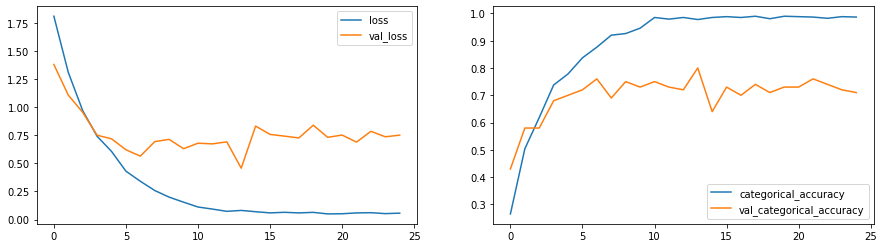

In [41]:
conv_gru_tl.train_model(conv_gru_model_tl,model_name="conv_gru_tl",model_type="CNN_GRU")
conv_gru_tl.plot_model()

### Observations and Thoughts:

- The best score in this model is loss: 0.4308 - categorical_accuracy: 0.8371 - val_loss: 0.6214 - val_categorical_accuracy: 0.7200 - lr: 0.0010
- lets push the accuracy by decreasing batch size & dropout and increasing frames to sample


### Model 13: MobileNet+GRU

- 25 frames to be sampled
- Batch size is 16
- Images cropped to (120,120)
- 128 dense neurons
- Epochs = 25
- dropout = 0.25
- gru cells = 128

In [12]:
conv_gru_tl2 = ConvGRU_Transfer()
conv_gru_tl2.initialize_path(project_folder_path)
conv_gru_tl2.initialize_image_properties(image_height=120,image_width=120)
conv_gru_tl2.initialize_hyperparams(frames_to_sample=25,batch_size=16,num_epochs=25)
conv_gru_tl2.initialize_modelparams()
conv_gru_model_tl2=conv_gru_tl2.model_architecture(gru_cells=128,dense_neurons=128,dropout=0.25)
conv_gru_model_tl2.summary()

Model: "sequential_3"



_________________________________________________________________



 Layer (type)                Output Shape              Param #   






 time_distributed_36 (TimeDi  (None, 25, 3, 3, 1024)   3228864   



 stributed)                                                      



                                                                 



 time_distributed_37 (TimeDi  (None, 25, 3, 3, 1024)   4096      



 stributed)                                                      



                                                                 



 time_distributed_38 (TimeDi  (None, 25, 1, 1, 1024)   0         



 stributed)                                                      



                                                                 



 time_distributed_39 (TimeDi  (None, 25, 1024)         0         



 stributed)                                                      



                                                                 



 gru_3

/tmp/ipykernel_302/4180867941.py:119: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/25


2023-11-06 13:04:49.890669: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


42/42 [==============================] - ETA: 0s - loss: 1.4255 - categorical_accuracy: 0.4178



Epoch 00001: val_loss improved from inf to 1.14040, saving model to /content/drive/MyDrive/conv_gru_tl2_2023-11-0613_04_44.055154/model-00001-1.42555-0.41780-1.14040-0.53000.h5



42/42 [==============================] - 102s 2s/step - loss: 1.4255 - categorical_accuracy: 0.4178 - val_loss: 1.1404 - val_categorical_accuracy: 0.5300 - lr: 0.0010



Epoch 2/25



42/42 [==============================] - ETA: 0s - loss: 0.6783 - categorical_accuracy: 0.7602



Epoch 00002: val_loss improved from 1.14040 to 0.79004, saving model to /content/drive/MyDrive/conv_gru_tl2_2023-11-0613_04_44.055154/model-00002-0.67827-0.76018-0.79004-0.70000.h5



42/42 [==============================] - 100s 2s/step - loss: 0.6783 - categorical_accuracy: 0.7602 - val_loss: 0.7900 - val_categorical_accuracy: 0.7000 - lr: 0.0010



Epoch 3/25



42/42 [==============================] - ETA: 0s - loss: 0.3788 - catego

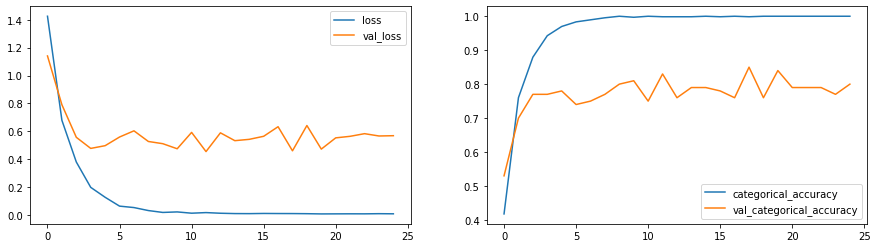

In [13]:
conv_gru_tl2.train_model(conv_gru_model_tl2,model_name="conv_gru_tl2",model_type="CNN_GRU")
conv_gru_tl2.plot_model()

### Observations and Thoughts:

- This just increased the overfitting and no improvisation validation loss and accuracy.We  see loss: 0.0069 - categorical_accuracy: 1.0000 - val_loss: 0.5678 - val_categorical_accuracy: 0.8000
- Let's increase the batch size to 64 and decrease the frames to sample from 25 to 20 and see if it helps.

### Model 14: MobileNet+GRU

- 20 frames to be sampled
- Batch size is 64
- Images cropped to (120,120)
- 128 dense neurons
- Epochs = 25
- dropout = 0.25
- gru cells = 128

In [14]:
conv_gru_tl3 = ConvGRU_Transfer()
conv_gru_tl3.initialize_path(project_folder_path)
conv_gru_tl3.initialize_image_properties(image_height=120,image_width=120)
conv_gru_tl3.initialize_hyperparams(frames_to_sample=20,batch_size=64,num_epochs=25)
conv_gru_tl3.initialize_modelparams()
conv_gru_model_tl3=conv_gru_tl3.model_architecture(gru_cells=128,dense_neurons=128,dropout=0.25)
conv_gru_model_tl3.summary()

Model: "sequential_4"



_________________________________________________________________



 Layer (type)                Output Shape              Param #   






 time_distributed_40 (TimeDi  (None, 20, 3, 3, 1024)   3228864   



 stributed)                                                      



                                                                 



 time_distributed_41 (TimeDi  (None, 20, 3, 3, 1024)   4096      



 stributed)                                                      



                                                                 



 time_distributed_42 (TimeDi  (None, 20, 1, 1, 1024)   0         



 stributed)                                                      



                                                                 



 time_distributed_43 (TimeDi  (None, 20, 1024)         0         



 stributed)                                                      



                                                                 



 gru_4

/tmp/ipykernel_302/4180867941.py:119: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/25



11/11 [==============================] - ETA: 0s - loss: 1.5572 - categorical_accuracy: 0.3318



Epoch 00001: val_loss improved from inf to 1.26194, saving model to /content/drive/MyDrive/conv_gru_tl3_2023-11-0613_45_36.928391/model-00001-1.55718-0.33183-1.26194-0.54000.h5



11/11 [==============================] - 82s 8s/step - loss: 1.5572 - categorical_accuracy: 0.3318 - val_loss: 1.2619 - val_categorical_accuracy: 0.5400 - lr: 0.0010



Epoch 2/25



11/11 [==============================] - ETA: 0s - loss: 0.8344 - categorical_accuracy: 0.7285



Epoch 00002: val_loss improved from 1.26194 to 0.99159, saving model to /content/drive/MyDrive/conv_gru_tl3_2023-11-0613_45_36.928391/model-00002-0.83439-0.72851-0.99159-0.57000.h5



11/11 [==============================] - 75s 8s/step - loss: 0.8344 - categorical_accuracy: 0.7285 - val_loss: 0.9916 - val_categorical_accuracy: 0.5700 - lr: 0.0010



Epoch 3/25



11/11 [==============================] - ETA: 0s - loss: 0.5

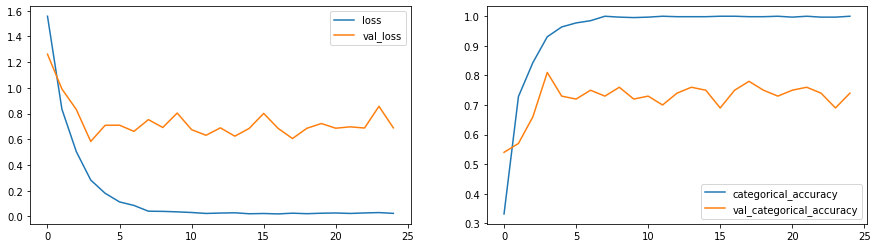

In [15]:
conv_gru_tl3.train_model(conv_gru_model_tl3,model_name="conv_gru_tl3",model_type="CNN_GRU")
conv_gru_tl3.plot_model()

### Observations and Thoughts:

- We see loss: 0.0250 - categorical_accuracy: 0.9985 - val_loss: 0.6058 - val_categorical_accuracy: 0.7800
- Lets reduce the number of parameters by reducing the gru cells and dense neurons to 64 from 128 each

### Model 15: MobileNet+GRU

- 20 frames to be sampled
- batch size is 64
- Images cropped to (120,120)
- 64 dense neurons
- Epochs = 25
- dropout = 0.25
- gru cells = 64
- Reducing the number of neurons of gru and dense layer

In [16]:
conv_gru_tl4 = ConvGRU_Transfer()
conv_gru_tl4.initialize_path(project_folder_path)
conv_gru_tl4.initialize_image_properties(image_height=120,image_width=120)
conv_gru_tl4.initialize_hyperparams(frames_to_sample=20,batch_size=64,num_epochs=25)
conv_gru_tl4.initialize_modelparams()
conv_gru_model_tl4=conv_gru_tl4.model_architecture(gru_cells=64,dense_neurons=64,dropout=0.25)
conv_gru_model_tl4.summary()

Model: "sequential_5"



_________________________________________________________________



 Layer (type)                Output Shape              Param #   






 time_distributed_44 (TimeDi  (None, 20, 3, 3, 1024)   3228864   



 stributed)                                                      



                                                                 



 time_distributed_45 (TimeDi  (None, 20, 3, 3, 1024)   4096      



 stributed)                                                      



                                                                 



 time_distributed_46 (TimeDi  (None, 20, 1, 1, 1024)   0         



 stributed)                                                      



                                                                 



 time_distributed_47 (TimeDi  (None, 20, 1024)         0         



 stributed)                                                      



                                                                 



 gru_5

/tmp/ipykernel_302/4180867941.py:119: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/25



11/11 [==============================] - ETA: 0s - loss: 1.6644 - categorical_accuracy: 0.2986



Epoch 00001: val_loss improved from inf to 1.34222, saving model to /content/drive/MyDrive/conv_gru_tl4_2023-11-0614_18_52.169447/model-00001-1.66445-0.29864-1.34222-0.41000.h5



11/11 [==============================] - 83s 8s/step - loss: 1.6644 - categorical_accuracy: 0.2986 - val_loss: 1.3422 - val_categorical_accuracy: 0.4100 - lr: 0.0010



Epoch 2/25



11/11 [==============================] - ETA: 0s - loss: 1.1181 - categorical_accuracy: 0.5626



Epoch 00002: val_loss improved from 1.34222 to 1.22240, saving model to /content/drive/MyDrive/conv_gru_tl4_2023-11-0614_18_52.169447/model-00002-1.11810-0.56259-1.22240-0.45000.h5



11/11 [==============================] - 75s 7s/step - loss: 1.1181 - categorical_accuracy: 0.5626 - val_loss: 1.2224 - val_categorical_accuracy: 0.4500 - lr: 0.0010



Epoch 3/25



11/11 [==============================] - ETA: 0s - loss: 0.8

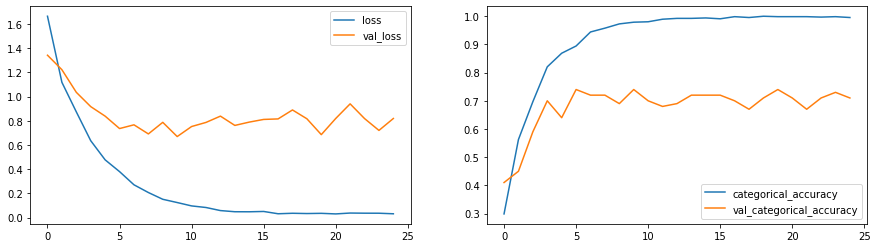

In [17]:
conv_gru_tl4.train_model(conv_gru_model_tl4,model_name="conv_gru_tl4",model_type="CNN_GRU")
conv_gru_tl4.plot_model()

### Observations and Thoughts:

- We see loss: 0.3801 - categorical_accuracy: 0.8944 - val_loss: 0.7360 - val_categorical_accuracy: 0.7400
- There is a slight increase in the validation loss from 0.6058 to 0.7360
- lets reduce the batch size to 8 and below configuration with previous increased dense and gru units of 128 , reduce the frames to 15

### Model 16: MobileNet+GRU

- 15 frames to be sampled
- Batch size is 8
- Images cropped to (120,120)
- 128 dense neurons
- Epochs = 25
- dropout = 0.25
- gru cells = 128

In [18]:
conv_gru_tl4_copy = ConvGRU_Transfer()
conv_gru_tl4_copy.initialize_path(project_folder_path)
conv_gru_tl4_copy.initialize_image_properties(image_height=120,image_width=120)
conv_gru_tl4_copy.initialize_hyperparams(frames_to_sample=15,batch_size=8,num_epochs=25)
conv_gru_tl4_copy.initialize_modelparams()
conv_gru_model_tl4_copy=conv_gru_tl4_copy.model_architecture(gru_cells=128,dense_neurons=128,dropout=0.25)
conv_gru_model_tl4_copy.summary()

Model: "sequential_6"



_________________________________________________________________



 Layer (type)                Output Shape              Param #   






 time_distributed_48 (TimeDi  (None, 15, 3, 3, 1024)   3228864   



 stributed)                                                      



                                                                 



 time_distributed_49 (TimeDi  (None, 15, 3, 3, 1024)   4096      



 stributed)                                                      



                                                                 



 time_distributed_50 (TimeDi  (None, 15, 1, 1, 1024)   0         



 stributed)                                                      



                                                                 



 time_distributed_51 (TimeDi  (None, 15, 1024)         0         



 stributed)                                                      



                                                                 



 gru_6

In [19]:
conv_gru_tl4_copy.train_model(conv_gru_model_tl4_copy,model_name="conv_gru_tl4_copy",model_type="CNN_GRU")

/tmp/ipykernel_302/4180867941.py:119: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/25



83/83 [==============================] - ETA: 0s - loss: 1.3595 - categorical_accuracy: 0.4253



Epoch 00001: val_loss improved from inf to 0.98996, saving model to /content/drive/MyDrive/conv_gru_tl4_copy_2023-11-0614_51_47.059116/model-00001-1.35951-0.42534-0.98996-0.66000.h5



83/83 [==============================] - 63s 728ms/step - loss: 1.3595 - categorical_accuracy: 0.4253 - val_loss: 0.9900 - val_categorical_accuracy: 0.6600 - lr: 0.0010



Epoch 2/25



83/83 [==============================] - ETA: 0s - loss: 0.6799 - categorical_accuracy: 0.7557



Epoch 00002: val_loss improved from 0.98996 to 0.78566, saving model to /content/drive/MyDrive/conv_gru_tl4_copy_2023-11-0614_51_47.059116/model-00002-0.67987-0.75566-0.78566-0.65000.h5



83/83 [==============================] - 60s 735ms/step - loss: 0.6799 - categorical_accuracy: 0.7557 - val_loss: 0.7857 - val_categorical_accuracy: 0.6500 - lr: 0.0010



Epoch 3/25



83/83 [==============================] - ETA

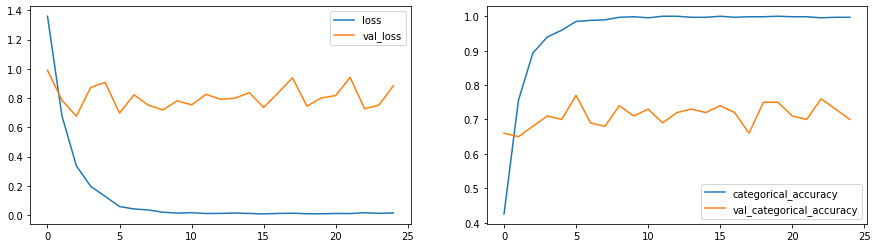

In [20]:
conv_gru_tl4_copy.plot_model()

### Observations and Thoughts:

- We see loss: 0.0164 - categorical_accuracy: 0.9955 - val_loss: 0.7269 - val_categorical_accuracy: 0.7600
- There is a slight increase in the validation loss from 0.7360 to 0.7600
- Lets try training on whole mobilenet model with the same parameters

### Model 17: MobileNet(on all the layers)+GRU

- 15 frames to be sampled
- Batch size is 8
- Images cropped to (120,120)
- 128 dense neurons
- Epochs = 25
- dropout = 0.25
- gru cells = 128

In [9]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class ConvGRU_Transfer_NoWeights(ModelClass):
    
    def model_architecture(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = True
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

conv_gru_tl4_now = ConvGRU_Transfer_NoWeights()
conv_gru_tl4_now.initialize_path(project_folder_path)
conv_gru_tl4_now.initialize_image_properties(image_height=120,image_width=120)
conv_gru_tl4_now.initialize_hyperparams(frames_to_sample=15,batch_size=8,num_epochs=25)
conv_gru_tl4_now.initialize_modelparams()
conv_gru_model_tl4_now=conv_gru_tl4_now.model_architecture(gru_cells=128,dense_neurons=128,dropout=0.25)
conv_gru_model_tl4_now.summary()


Model: "sequential_2"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 time_distributed_4 (TimeDis  (None, 15, 3, 3, 1024)   3228864   

 tributed)                                                       

                                                                 

 time_distributed_5 (TimeDis  (None, 15, 3, 3, 1024)   4096      

 tributed)                                                       

                                                                 

 time_distributed_6 (TimeDis  (None, 15, 1, 1, 1024)   0         

 tributed)                                                       

                                                                 

 time_distributed_7 (TimeDis  (None, 15, 1024)         0         

 tributed)                                                       

                                                                 

 gru_1 (GRU)                 (None, 1

In [10]:
conv_gru_tl4_now.train_model(conv_gru_model_tl4_now,model_name="conv_gru_tl4_now",model_type="CNN_GRU")

/tmp/ipykernel_400/1876292688.py:119: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.

  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/25


2023-11-08 04:52:50.869992: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


83/83 [==============================] - ETA: 0s - loss: 1.2100 - categorical_accuracy: 0.5249

Epoch 00001: val_loss improved from inf to 0.86869, saving model to conv_gru_tl4_now_2023-11-0804_52_45.277269/model-00001-1.21005-0.52489-0.86869-0.65000.h5

83/83 [==============================] - 69s 754ms/step - loss: 1.2100 - categorical_accuracy: 0.5249 - val_loss: 0.8687 - val_categorical_accuracy: 0.6500 - lr: 0.0010

Epoch 2/25

83/83 [==============================] - ETA: 0s - loss: 0.6273 - categorical_accuracy: 0.7768

Epoch 00002: val_loss improved from 0.86869 to 0.50631, saving model to conv_gru_tl4_now_2023-11-0804_52_45.277269/model-00002-0.62727-0.77677-0.50631-0.82000.h5

83/83 [==============================] - 61s 743ms/step - loss: 0.6273 - categorical_accuracy: 0.7768 - val_loss: 0.5063 - val_categorical_accuracy: 0.8200 - lr: 0.0010

Epoch 3/25

83/83 [==============================] - ETA: 0s - loss: 0.4185 - categorical_accuracy: 0.8688

Epoch 00003: val_loss did 

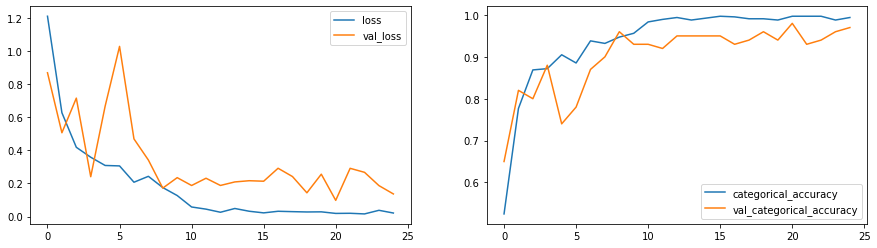

In [11]:
conv_gru_tl4_now.plot_model()

### Observations and Thoughts:

- we see loss: 0.0191 - categorical_accuracy: 0.9970 - val_loss: 0.0980 - val_categorical_accuracy: 0.9800       # Epoch - 21
- This is the best model till now with the highest validation accuracy of 98% and least validation loss of just 0.0980

## Which Model to Choose?? We got a good accuracy of two models:
### Conv3D
- Model3 -> Conv3D -> Epoch26th Model -> Validation accuracy 84% -> validation loss 0.5910  - Total params: 1,155,397
- Trainable params: 1,154,405
- Non-trainable params: 992
### MobileNet(with complete training over all the layers) + GRU
- Model17 -> MobileNet(with complete training over all the layers) + GRU -> epoch 21st Model -> Validation accuracy 98% -> validation loss 0.0980 
- Total params: 3,693,253
- Trainable params: 3,669,317
- Non-trainable params: 23,936

### We select the second one which is the MobileNet+GRU for the following reasons:

- The validation loss is way lesser ~0.0980 than the conv3D Model with 0.5910
- The accuracy is 98% which is remarkable than Conv3D model with 84%
- Trainable params are almost thrice but a 42MB model is not a huge model when compared to CNNs which end up in GBs.
- Models in MBs are easily deployable on smart devices.

### Testing the model on a random batch in validation set

In [12]:
# loading the model
import time
from keras.models import load_model
model = load_model('conv_gru_tl4_now_2023-11-0804_52_45.277269/model-00021-0.01909-0.99698-0.09796-0.98000.h5')

In [13]:
test_generator=ConvGRU_Transfer_NoWeights()
test_generator.initialize_path(project_folder_path)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=15,batch_size=8,num_epochs=25)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,model_type="Conv_GRU")
batch_data, batch_labels=next(g)

In [14]:
batch_labels   # True labels 

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

In [15]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1)) ## predicted labels

[2 4 0 1 3 1 4 1]
